In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import janitor as jn
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    cohen_kappa_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)
from yellowbrick.model_selection import (
    LearningCurve 
)

from imblearn.over_sampling import (
    SMOTE, ADASYN
)
from seaborn import diverging_palette

In [39]:
fraud_labels.describe()

count    10699.000000
mean         0.062529
std          0.242126
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FraudFound_P, dtype: float64

In [62]:
fraud_labels.value_counts()

0    10030
1      669
Name: FraudFound_P, dtype: int64

In [40]:
X_train, X_val_test, y_train, y_val_test = train_test_split(fraud,fraud_labels, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5, random_state=0)

## Evaluation Metrics

### ROC Curve

In [41]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [42]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [43]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

### Classification Metrics

In [44]:
def evaluation_metrics(y_actual, y_pred):
            
        precision, recall, _ = precision_recall_curve(y_actual, y_pred)
        average_precision = average_precision_score(y_actual, y_pred)
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        roc_auc = roc_auc_score(y_actual, y_pred)
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_actual, y_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))

## Dealing with imbalanced classes

### Visualize support for each class 

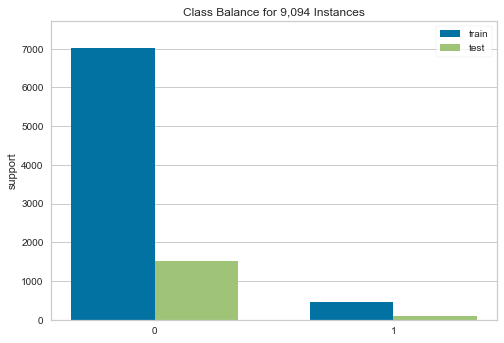

<AxesSubplot:title={'center':'Class Balance for 9,094 Instances'}, ylabel='support'>

In [45]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### SMOTE (Synthetic Minority Oversampling Technique)
Up-Sampling under represented class

In [46]:
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

### Over Sampling

In [47]:
from imblearn.over_sampling import (
    RandomOverSampler,
)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
pd.Series(y_train_ros).value_counts()

0    7017
1    7017
Name: FraudFound_P, dtype: int64

###  Adaptive Synthetic (ADASYN)

In [48]:
adasyn = ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

### Combining Over Sampling and Under Sampling

#### SMOTEENN

In [49]:
from imblearn.combine import SMOTEENN
from collections import Counter
smote_enn = SMOTEENN(random_state=0)
X_train_smoteen, y_train_smoteen = smote_enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_smoteen).items()))

[(0, 4471), (1, 7016)]


#### SMOTETomek

In [51]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_smotetomek).items()))

[(0, 7017), (1, 7017)]


## KNN

### Default

Validation Result:

accuracy score: 0.9408



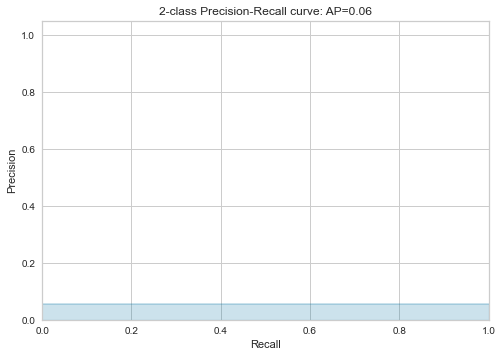

roc auc score: 0.4986789960369881



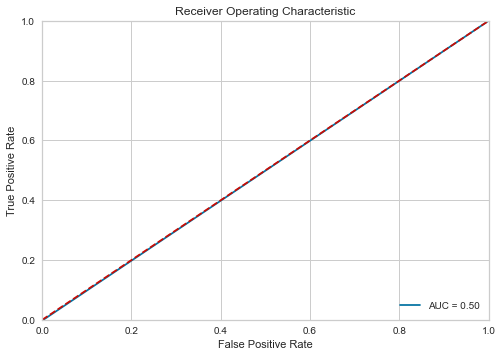

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1514
           1       0.00      0.00      0.00        91

    accuracy                           0.94      1605
   macro avg       0.47      0.50      0.48      1605
weighted avg       0.89      0.94      0.91      1605


Confusion Matrix: 
 [[1510    4]
 [  91    0]]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


End of validation Result



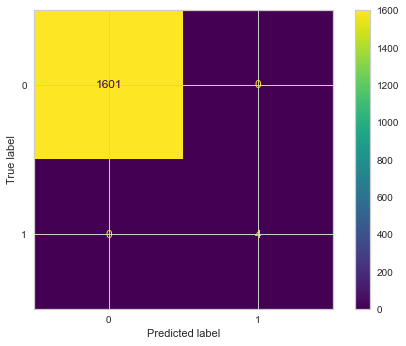

In [52]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
clf_score(clf_knn, X_train, y_train, X_val, y_val, train=False)

## KNN - Imbalanced - Smote

Validation Result:

accuracy score: 0.6424



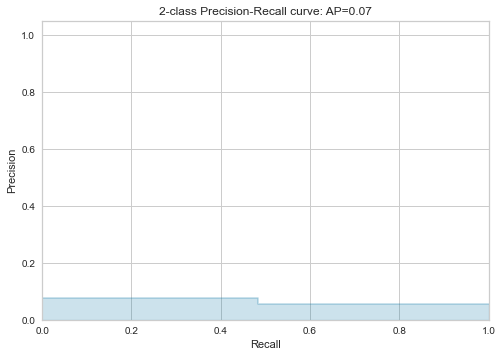

roc auc score: 0.5677159696314253



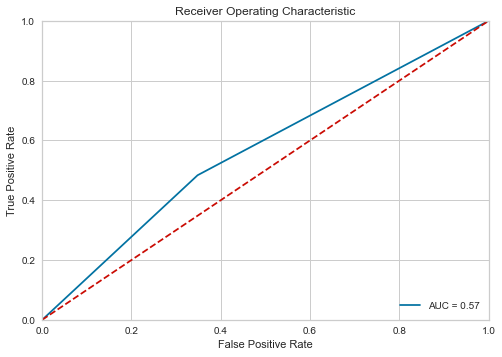

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.65      0.77      1514
           1       0.08      0.48      0.13        91

    accuracy                           0.64      1605
   macro avg       0.52      0.57      0.45      1605
weighted avg       0.90      0.64      0.74      1605


Confusion Matrix: 
 [[987 527]
 [ 47  44]]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


End of validation Result



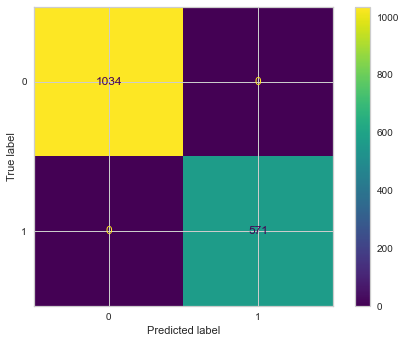

In [53]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train_sm, y_train_sm)
clf_score(clf_knn, X_train_sm, y_train_sm, X_val, y_val, train=False)

## KNN - Imbalanced - Over Sampling

Validation Result:

accuracy score: 0.7931



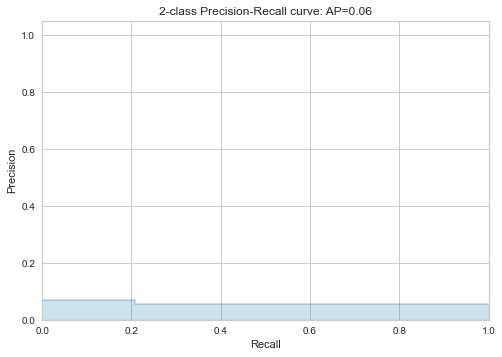

roc auc score: 0.5185303467998316



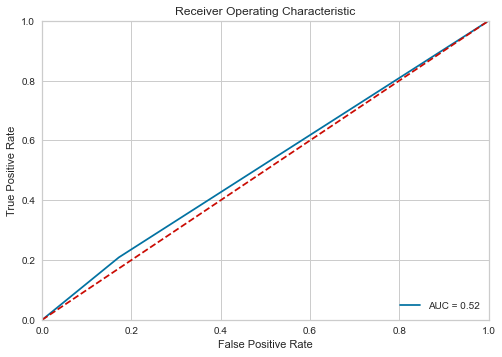

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.83      0.88      1514
           1       0.07      0.21      0.10        91

    accuracy                           0.79      1605
   macro avg       0.51      0.52      0.49      1605
weighted avg       0.90      0.79      0.84      1605


Confusion Matrix: 
 [[1254  260]
 [  72   19]]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


End of validation Result



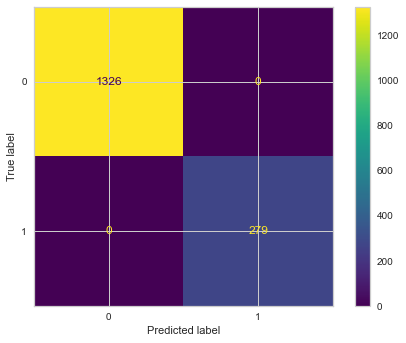

In [70]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_ros, y_train_ros)

clf_score(clf_knn, X_train_ros, y_train_ros, X_val, y_val, train=False)

## KNN - Imbalanced - Adasyn

Validation Result:

accuracy score: 0.6748



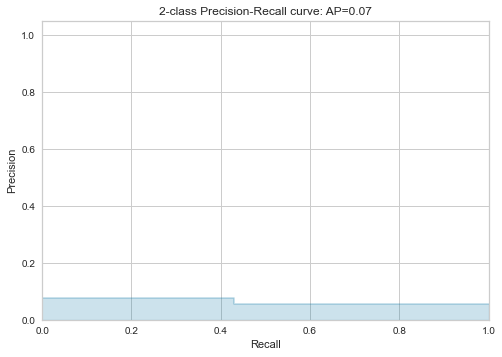

roc auc score: 0.5590677486318173



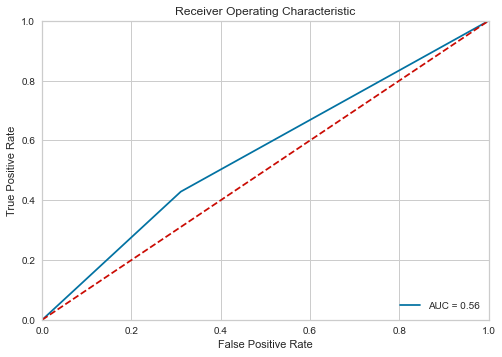

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.69      0.80      1514
           1       0.08      0.43      0.13        91

    accuracy                           0.67      1605
   macro avg       0.51      0.56      0.47      1605
weighted avg       0.90      0.67      0.76      1605


Confusion Matrix: 
 [[1044  470]
 [  52   39]]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


End of validation Result



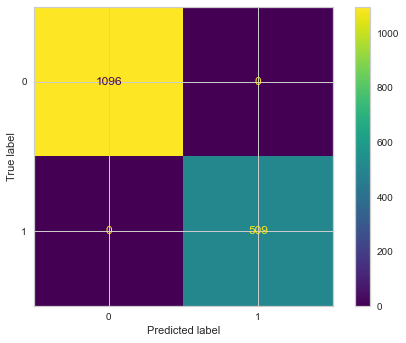

In [71]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_adasyn, y_train_adasyn)

clf_score(clf_knn, X_train_adasyn, y_train_adasyn, X_val, y_val, train=False)

## KNN - Imbalanced - SMOTEENN

Validation Result:

accuracy score: 0.5664



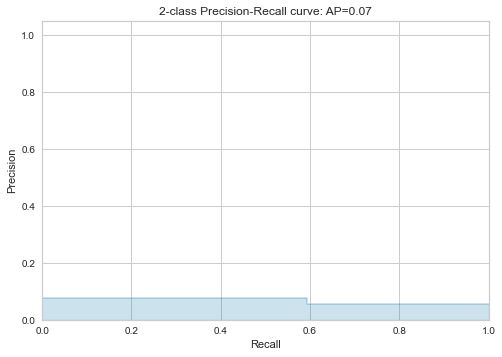

roc auc score: 0.579067893797088



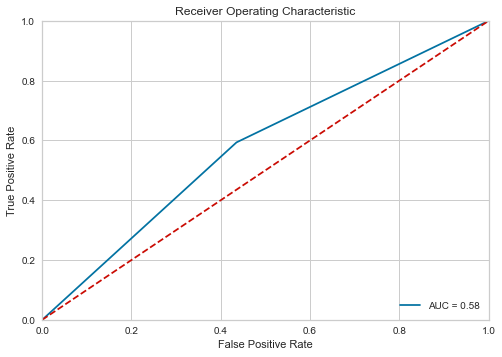

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.56      0.71      1514
           1       0.08      0.59      0.13        91

    accuracy                           0.57      1605
   macro avg       0.52      0.58      0.42      1605
weighted avg       0.91      0.57      0.68      1605


Confusion Matrix: 
 [[855 659]
 [ 37  54]]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


End of validation Result



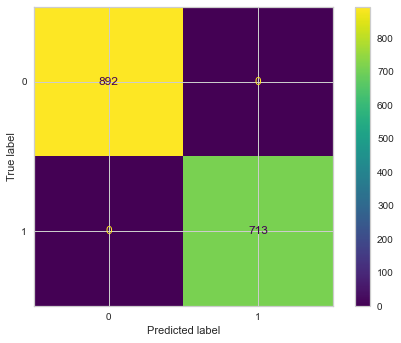

In [72]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_smoteen, y_train_smoteen)

clf_score(clf_knn, X_train_smoteen, y_train_smoteen, X_val, y_val, train=False)

## KNN - Imbalanced - SMOTETomek

Validation Result:

accuracy score: 0.6785



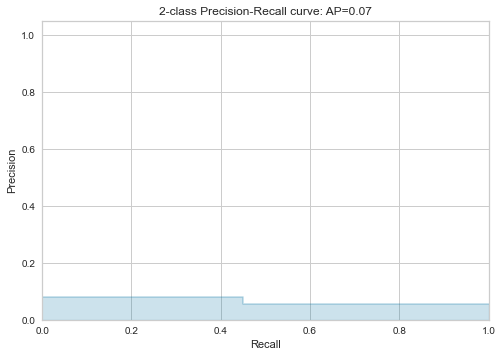

roc auc score: 0.5713777635838402



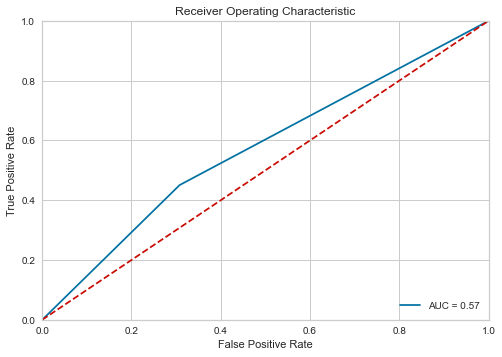

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.69      0.80      1514
           1       0.08      0.45      0.14        91

    accuracy                           0.68      1605
   macro avg       0.52      0.57      0.47      1605
weighted avg       0.90      0.68      0.76      1605


Confusion Matrix: 
 [[1048  466]
 [  50   41]]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


End of validation Result



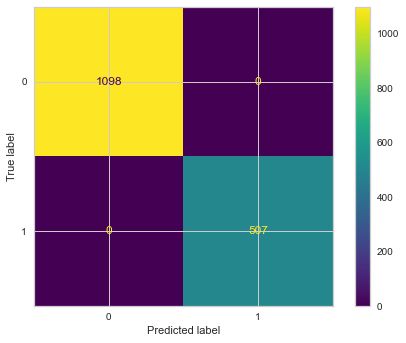

In [54]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_smotetomek, y_train_smotetomek)

clf_score(clf_knn, X_train_smotetomek, y_train_smotetomek, X_val, y_val, train=False)

### Evaluate model on test set - KNN - Imbalanced - SMOTEENN

#### Class Prediction Error

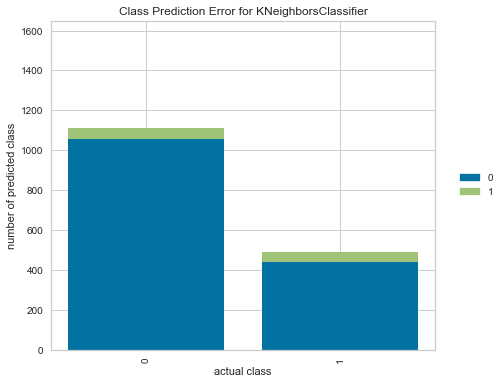

<AxesSubplot:title={'center':'Class Prediction Error for KNeighborsClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [65]:
from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(
    clf_knn, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train_smoteen, y_train_smoteen)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

#### Classification Report

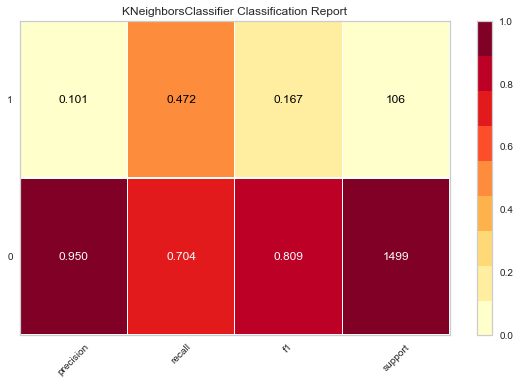

<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>

In [66]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(
    clf_knn, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train_smoteen, y_train_smoteen)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion Matrix

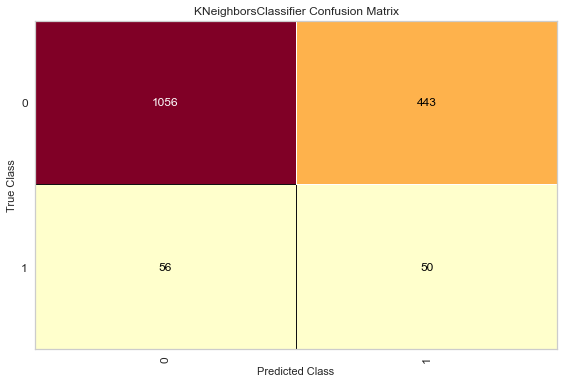

<AxesSubplot:title={'center':'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [67]:
from yellowbrick.classifier import confusion_matrix

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(clf_knn, classes=[0,1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_smoteen, y_train_smoteen)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

#### PR Curve

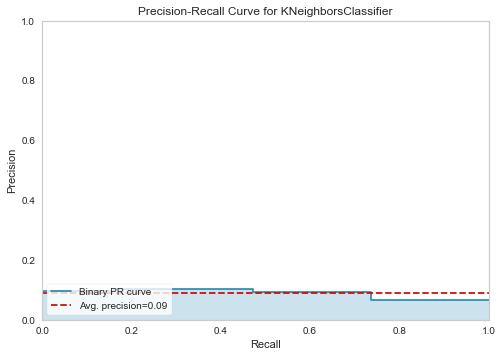

<AxesSubplot:title={'center':'Precision-Recall Curve for KNeighborsClassifier'}, xlabel='Recall', ylabel='Precision'>

In [78]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_knn, is_fitted=True)
viz.fit(X_train_sm, y_train_sm)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

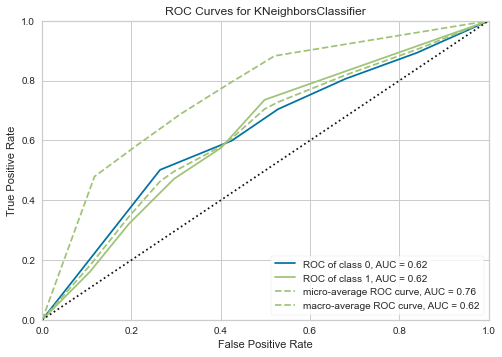

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [79]:
visualizer = ROCAUC(
    clf_knn, classes=classes, is_fitted=True
)

visualizer.fit(X_train_sm, y_train_sm)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

#### Validation Curve

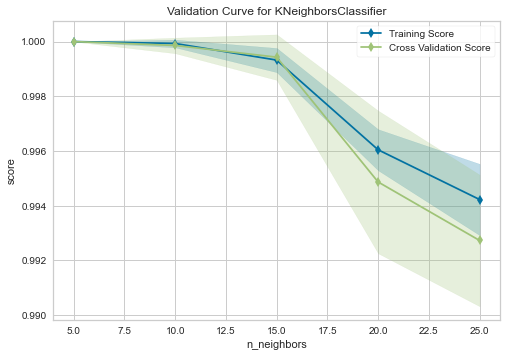

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='n_neighbors', ylabel='score'>

In [71]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    KNeighborsClassifier(), 
    param_name="n_neighbors",
    param_range=[5,10,15,20,25], 
    cv=5, 
    scoring="recall",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train_sm, y_train_sm)
viz.poof()

## GaussianNB

### Default

Validation Result:

accuracy score: 0.8922



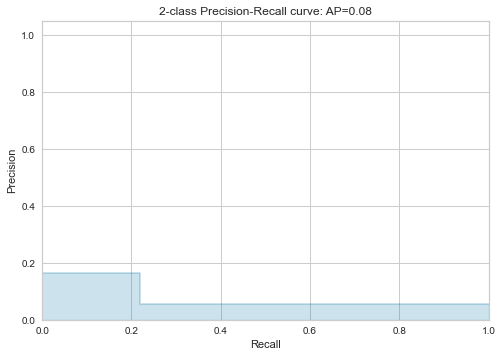

roc auc score: 0.5762045088333068



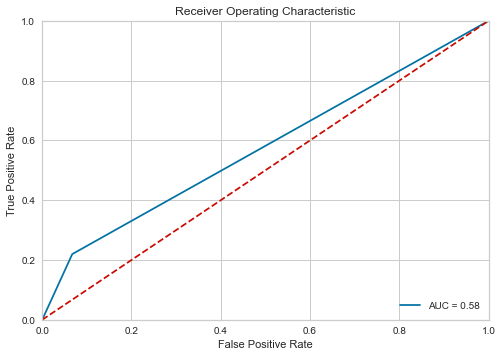

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1514
           1       0.16      0.22      0.19        91

    accuracy                           0.89      1605
   macro avg       0.56      0.58      0.57      1605
weighted avg       0.91      0.89      0.90      1605


Confusion Matrix: 
 [[1412  102]
 [  71   20]]

End of validation Result



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


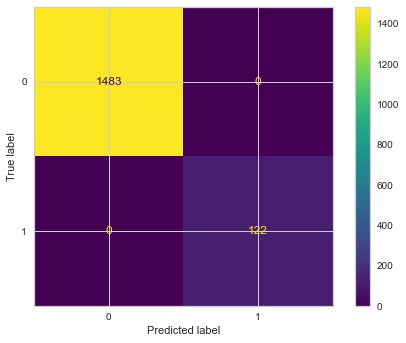

In [56]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
clf_score(clf_gnb, X_train, y_train, X_val, y_val, train=False)

## GaussianNB - Imbalanced - Smote

Validation Result:

accuracy score: 0.6455



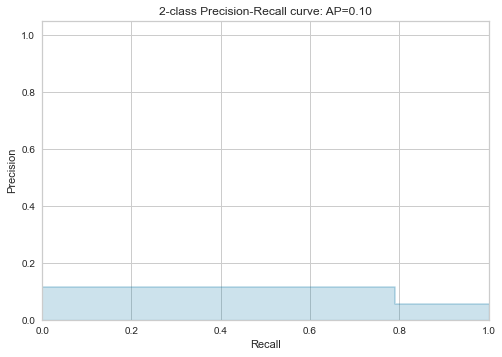

roc auc score: 0.7139663506902609



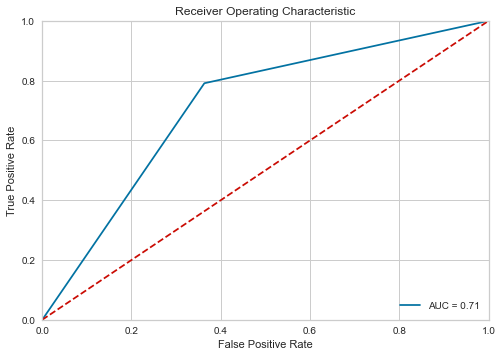

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.64      0.77      1514
           1       0.12      0.79      0.20        91

    accuracy                           0.65      1605
   macro avg       0.55      0.71      0.49      1605
weighted avg       0.93      0.65      0.74      1605


Confusion Matrix: 
 [[964 550]
 [ 19  72]]

End of validation Result



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


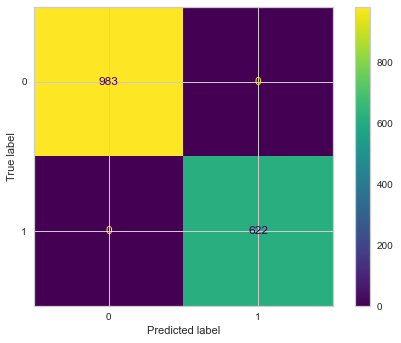

In [57]:
clf_gnb.fit(X_train_sm, y_train_sm)
clf_score(clf_gnb, X_train_sm, y_train_sm, X_val, y_val, train=False)

## GaussianNB - Imbalanced - Over Sampling

Validation Result:

accuracy score: 0.6754



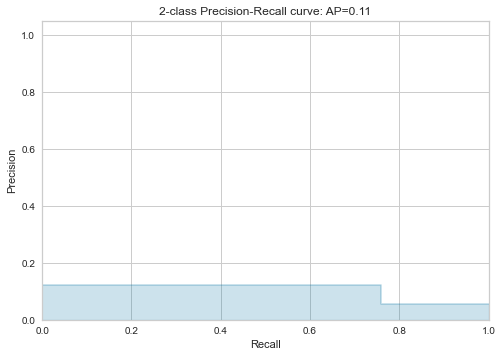

roc auc score: 0.714325634735146



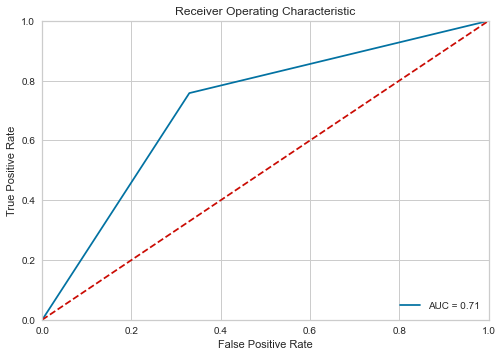

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.67      0.80      1514
           1       0.12      0.76      0.21        91

    accuracy                           0.68      1605
   macro avg       0.55      0.71      0.50      1605
weighted avg       0.93      0.68      0.76      1605


Confusion Matrix: 
 [[1015  499]
 [  22   69]]

End of validation Result



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


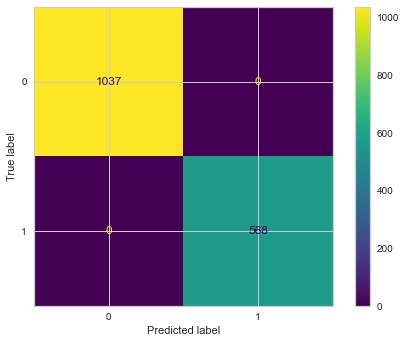

In [58]:
clf_gnb.fit(X_train_ros, y_train_ros)

clf_score(clf_gnb, X_train_ros, y_train_ros, X_val, y_val, train=False)

## GaussianNB - Imbalanced - Adasyn

Validation Result:

accuracy score: 0.6393



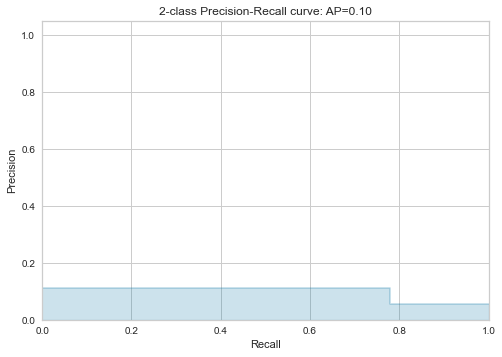

roc auc score: 0.7054995862789786



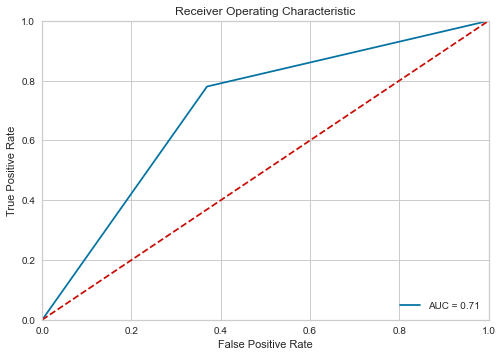

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.63      0.77      1514
           1       0.11      0.78      0.20        91

    accuracy                           0.64      1605
   macro avg       0.55      0.71      0.48      1605
weighted avg       0.93      0.64      0.74      1605


Confusion Matrix: 
 [[955 559]
 [ 20  71]]

End of validation Result



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


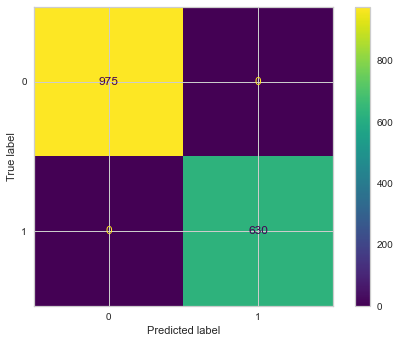

In [59]:
clf_gnb.fit(X_train_adasyn, y_train_adasyn)

clf_score(clf_gnb, X_train_adasyn, y_train_adasyn, X_val, y_val, train=False)

## GaussianNB - Imbalanced - SMOTEENN

Validation Result:

accuracy score: 0.6330



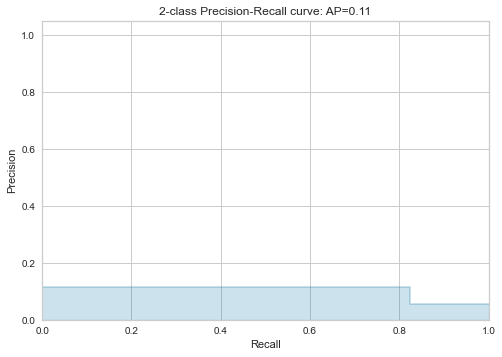

roc auc score: 0.722854094386459



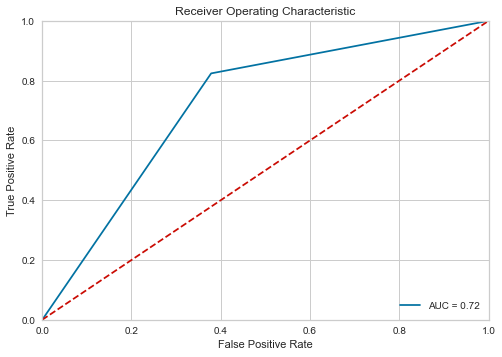

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.62      0.76      1514
           1       0.12      0.82      0.20        91

    accuracy                           0.63      1605
   macro avg       0.55      0.72      0.48      1605
weighted avg       0.93      0.63      0.73      1605


Confusion Matrix: 
 [[941 573]
 [ 16  75]]

End of validation Result



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


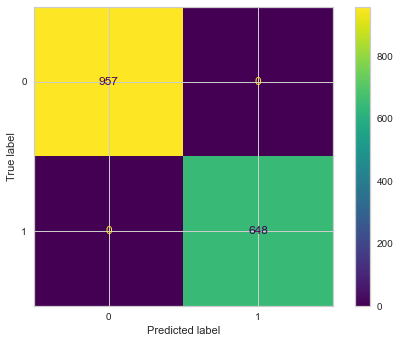

In [60]:
clf_gnb.fit(X_train_smoteen, y_train_smoteen)

clf_score(clf_gnb, X_train_smoteen, y_train_smoteen, X_val, y_val, train=False)

## GaussianNB - Imbalanced - SMOTETomek

Validation Result:

accuracy score: 0.6455



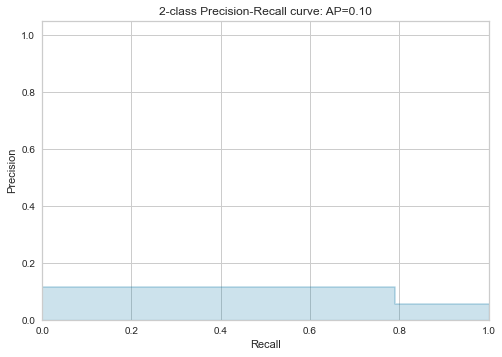

roc auc score: 0.7139663506902609



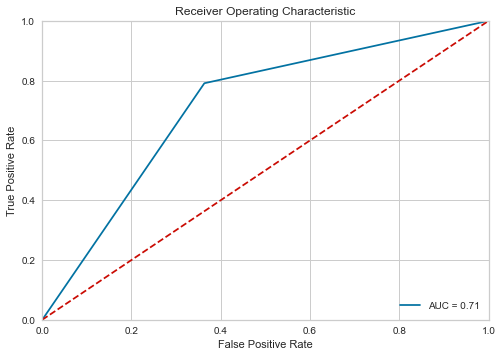

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.64      0.77      1514
           1       0.12      0.79      0.20        91

    accuracy                           0.65      1605
   macro avg       0.55      0.71      0.49      1605
weighted avg       0.93      0.65      0.74      1605


Confusion Matrix: 
 [[964 550]
 [ 19  72]]

End of validation Result



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


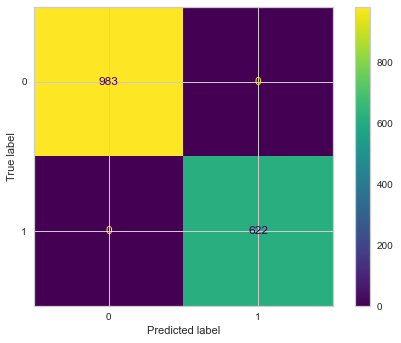

In [61]:
clf_gnb.fit(X_train_smotetomek, y_train_smotetomek)

clf_score(clf_gnb, X_train_smotetomek, y_train_smotetomek, X_val, y_val, train=False)

### Evaluate model on test set - GaussianNB - Imbalanced - SMOTEENN

#### Class Prediction Error

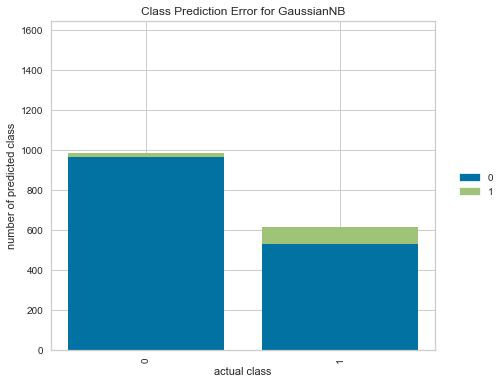

<AxesSubplot:title={'center':'Class Prediction Error for GaussianNB'}, xlabel='actual class', ylabel='number of predicted class'>

In [63]:
from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(
    clf_gnb, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train_smoteen, y_train_smoteen)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

#### Classification Report

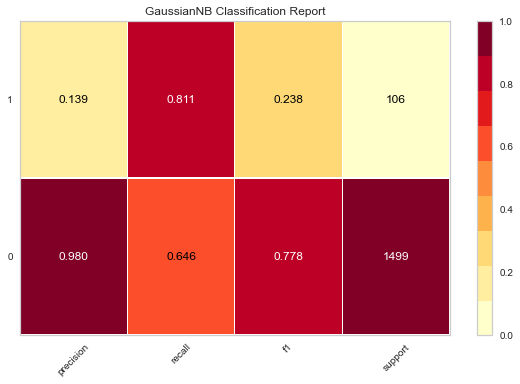

<AxesSubplot:title={'center':'GaussianNB Classification Report'}>

In [64]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(
    clf_gnb, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train_smoteen, y_train_smoteen)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion Matrix

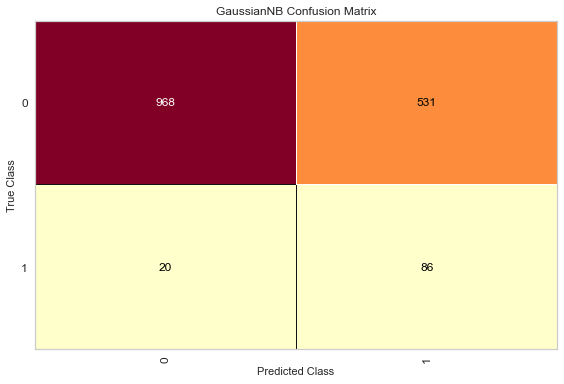

<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [68]:
from yellowbrick.classifier import confusion_matrix

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(clf_gnb, classes=[0,1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_smoteen, y_train_smoteen)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

#### PR Curve

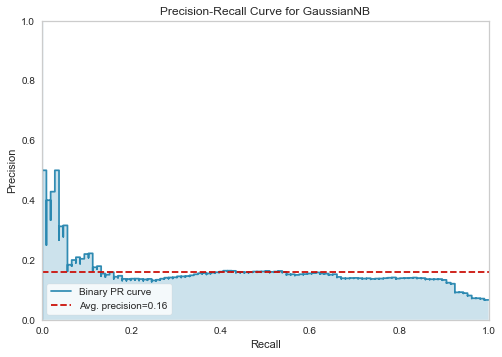

<AxesSubplot:title={'center':'Precision-Recall Curve for GaussianNB'}, xlabel='Recall', ylabel='Precision'>

In [69]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_gnb, is_fitted=True)
viz.fit(X_train_smoteen, y_train_smoteen)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

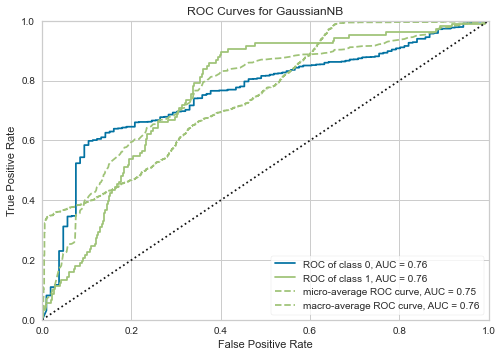

<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [70]:
visualizer = ROCAUC(
    clf_gnb, classes=classes, is_fitted=True
)

visualizer.fit(X_train_smoteen, y_train_smoteen)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  